In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics
from catboost import CatBoostClassifier 
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB

pd.options.display.max_rows = 120
pd.options.display.max_columns = 120

In [16]:
data_df = pd.read_csv('spam.csv')
data_df['Message'].isna().sum()
data_df["Category"] = data_df["Category"].replace(["spam", "ham"], [1,0])
print(f'spam percent is {data_df["Category"].sum() / len(data_df["Category"]) * 100} %')

spam percent is 13.406317300789663 %


In [17]:
data_df['length'] = data_df['Message'].apply(len)

Text(0.5, 0, 'Message Length')

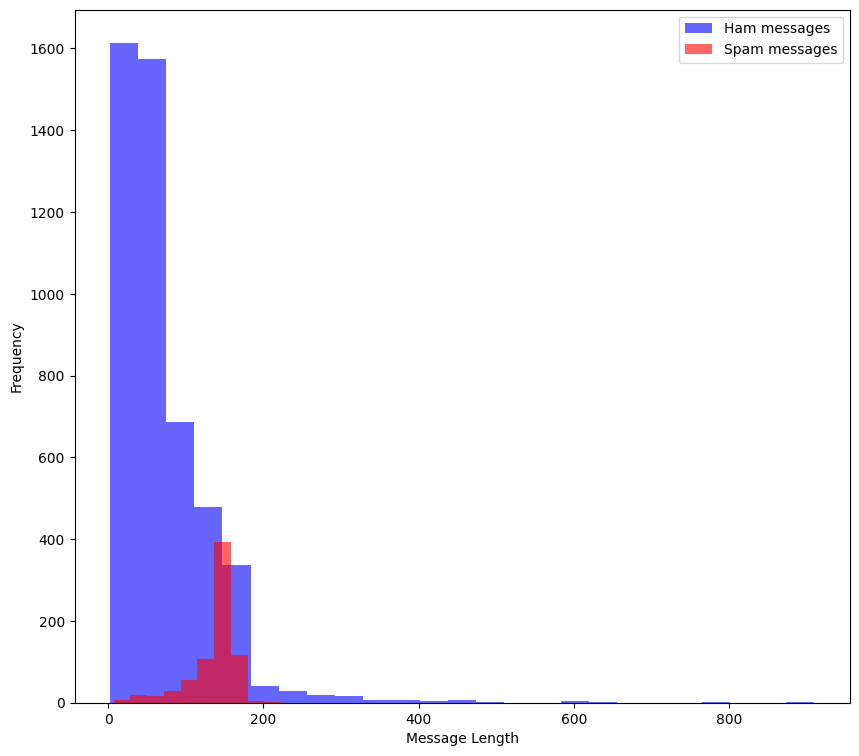

In [18]:
plt.figure(figsize=(10,9))
data_df[data_df['Category'] == 0]["length"].plot(bins=25, kind='hist', color='blue', 
                                       label='Ham messages', alpha=0.6)
data_df[data_df['Category'] == 1]["length"].plot(kind='hist', color='red', 
                                       label='Spam messages', alpha=0.6)
plt.legend()
plt.xlabel("Message Length")


In [19]:
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

def discard_irrelevant_chars(str : str):
    stopwords_list = stopwords.words('english') + ['u', 'ur', 'th', '4', '2', 'im', 'dont', 'ure']
    without_punct = [char for char in str if char not in string.punctuation]
    without_punct = ''.join(without_punct)
    return " ".join([word for word in without_punct.split() if word.lower() not in stopwords_list])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Murav\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
data_df['clean_msg'] = data_df['Message'].apply(discard_irrelevant_chars)
data_df

,Category,Message,length,clean_msg
0,0,"Go until jurong point, crazy.. Available only ...",111,Go jurong point crazy Available bugis n great ...
1,0,Ok lar... Joking wif u oni...,29,Ok lar Joking wif oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,Free entry wkly comp win FA Cup final tkts 21s...
3,0,U dun say so early hor... U c already then say...,49,dun say early hor c already say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,Nah think goes usf lives around though
...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,160,2nd time tried contact £750 Pound prize claim ...
5568,0,Will ü b going to esplanade fr home?,36,ü b going esplanade fr home
5569,0,"Pity, * was in mood for that. So...any other s...",57,Pity mood Soany suggestions
5570,0,The guy did some bitching but I acted like i'd...,125,guy bitching acted like id interested buying s...


In [21]:
from collections import Counter

words = data_df[data_df.Category == 0].clean_msg.apply(lambda x: [word.lower() for word in x.split()])

ham_words = Counter()

for msg in words:
    ham_words.update(msg)
    
print(ham_words.most_common(50))

[('get', 303), ('ltgt', 276), ('ok', 273), ('go', 250), ('ill', 238), ('got', 232), ('know', 232), ('like', 231), ('call', 231), ('come', 227), ('good', 224), ('love', 190), ('time', 189), ('day', 188), ('ü', 169), ('going', 167), ('want', 164), ('one', 163), ('home', 160), ('lor', 160), ('need', 157), ('sorry', 153), ('still', 147), ('see', 138), ('n', 137), ('later', 134), ('da', 131), ('r', 131), ('back', 129), ('think', 128), ('well', 127), ('today', 125), ('send', 123), ('tell', 121), ('cant', 119), ('hi', 117), ('take', 112), ('oh', 112), ('much', 112), ('night', 109), ('happy', 106), ('hey', 106), ('great', 100), ('way', 100), ('hope', 100), ('pls', 98), ('work', 97), ('wat', 95), ('thats', 95), ('give', 94)]


In [22]:
words = data_df[data_df.Category == 1].clean_msg.apply(lambda x: [word.lower() for word in x.split()])

ham_words = Counter()

for msg in words:
    ham_words.update(msg)
    
print(ham_words.most_common(50))

[('call', 344), ('free', 216), ('txt', 150), ('mobile', 123), ('text', 120), ('stop', 115), ('claim', 111), ('reply', 101), ('prize', 90), ('get', 83), ('new', 69), ('send', 68), ('nokia', 65), ('cash', 62), ('urgent', 62), ('win', 60), ('service', 55), ('contact', 55), ('please', 52), ('16', 51), ('guaranteed', 50), ('customer', 49), ('week', 49), ('tone', 48), ('per', 46), ('phone', 45), ('chat', 42), ('18', 41), ('awarded', 38), ('latest', 36), ('draw', 36), ('£1000', 35), ('line', 35), ('mins', 34), ('receive', 33), ('camera', 33), ('1', 33), ('box', 33), ('every', 33), ('message', 32), ('po', 32), ('holiday', 32), ('landline', 32), ('shows', 31), ('150ppm', 31), ('£2000', 31), ('go', 31), ('number', 30), ('apply', 29), ('code', 29)]


In [23]:
X = data_df.drop(columns=['Message', "Category"])
y = data_df["Category"]
X

,length,clean_msg
0,111,Go jurong point crazy Available bugis n great ...
1,29,Ok lar Joking wif oni
2,155,Free entry wkly comp win FA Cup final tkts 21s...
3,49,dun say early hor c already say
4,61,Nah think goes usf lives around though
...,...,...
5567,160,2nd time tried contact £750 Pound prize claim ...
5568,36,ü b going esplanade fr home
5569,57,Pity mood Soany suggestions
5570,125,guy bitching acted like id interested buying s...


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=543, test_size=0.2)


CountVectorizer возвращает разреженную матрицу, где каждый столбец - слово, каждая строчка - высказывание, значение ячейки - количество использований слова в данном высказывании.
Минус: игнорируется порядок слов


In [25]:
from sklearn.feature_extraction.text  import CountVectorizer
vect = CountVectorizer()
vect.fit(X_train["clean_msg"])

X_train_dtm = vect.transform(X_train["clean_msg"])

print(type(X_train_dtm), X_train_dtm.shape, len(y_train))

X_test_dtm = vect.transform(X_test["clean_msg"])
print(type(X_test_dtm), X_test_dtm.shape, len(y_test))

<class 'scipy.sparse._csr.csr_matrix'> (4457, 8312) 4457
<class 'scipy.sparse._csr.csr_matrix'> (1115, 8312) 1115


$$TF(t,d)= \frac {Общее количество терминов в документе d} {Количество вхождений термина t в документ d}$$
​
$$IDF(t) = \log (\frac {Общее количество документов в коллекции} {количество документов содержащих термин + 1}) + 1$$
$$TFIDF = IDF * TF$$

In [26]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

tfidf_transformer.fit(X_train_dtm)
X_train_TFIDF = tfidf_transformer.transform(X_train_dtm)

tfidf_transformer.fit(X_test_dtm)
X_test_TFIDF = tfidf_transformer.transform(X_test_dtm)

print(type(X_train_TFIDF), X_train_TFIDF.shape, len(y_train))

print(type(X_test_TFIDF), X_test_TFIDF.shape, len(y_test))


<class 'scipy.sparse._csr.csr_matrix'> (4457, 8312) 4457
<class 'scipy.sparse._csr.csr_matrix'> (1115, 8312) 1115


Learning rate set to 0.019502
0:	learn: 0.6704295	total: 61.2ms	remaining: 1m 1s
1:	learn: 0.6500826	total: 120ms	remaining: 59.8s
2:	learn: 0.6299728	total: 178ms	remaining: 59s
3:	learn: 0.6116572	total: 243ms	remaining: 1m
4:	learn: 0.5937870	total: 309ms	remaining: 1m 1s
5:	learn: 0.5772826	total: 381ms	remaining: 1m 3s
6:	learn: 0.5590720	total: 448ms	remaining: 1m 3s
7:	learn: 0.5430464	total: 518ms	remaining: 1m 4s
8:	learn: 0.5289486	total: 567ms	remaining: 1m 2s
9:	learn: 0.5175368	total: 620ms	remaining: 1m 1s
10:	learn: 0.5034720	total: 687ms	remaining: 1m 1s
11:	learn: 0.4890557	total: 739ms	remaining: 1m
12:	learn: 0.4758388	total: 807ms	remaining: 1m 1s
13:	learn: 0.4640775	total: 874ms	remaining: 1m 1s
14:	learn: 0.4518390	total: 930ms	remaining: 1m 1s
15:	learn: 0.4417412	total: 979ms	remaining: 1m
16:	learn: 0.4313043	total: 1.04s	remaining: 1m
17:	learn: 0.4213575	total: 1.11s	remaining: 1m
18:	learn: 0.4134483	total: 1.17s	remaining: 1m
19:	learn: 0.4037241	total: 1.

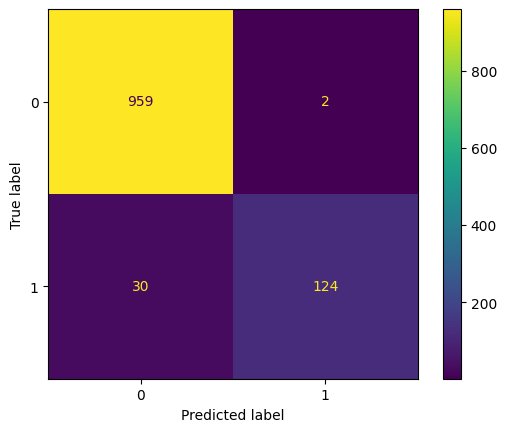

In [70]:
catb = CatBoostClassifier()
catb.fit(X_train_dtm, y_train)
predict_dtm = catb.predict(X_test_dtm)
print(metrics.accuracy_score(y_test, predict_dtm))
confusion_matrix_dtm = metrics.confusion_matrix(y_test, predict_dtm)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix_dtm, display_labels=catb.classes_)
disp.plot()
plt.show()
# 0.9713004484304932 1m

In [71]:
catb = CatBoostClassifier()
catb.fit(X_train_TFIDF, y_train)
predict_TFIDF = catb.predict(X_test_TFIDF)
print(metrics.accuracy_score(y_test, predict_TFIDF))
confusion_matrix_dtm = metrics.confusion_matrix(y_test, predict_TFIDF)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix_dtm, display_labels=catb.classes_)
disp.plot()
plt.show()
# 0.968609865470852 1m

Learning rate set to 0.019502
0:	learn: 0.6705495	total: 74.2ms	remaining: 1m 14s
1:	learn: 0.6491685	total: 146ms	remaining: 1m 13s
2:	learn: 0.6297448	total: 222ms	remaining: 1m 13s
3:	learn: 0.6108189	total: 296ms	remaining: 1m 13s
4:	learn: 0.5926191	total: 369ms	remaining: 1m 13s
5:	learn: 0.5739809	total: 443ms	remaining: 1m 13s
6:	learn: 0.5551149	total: 514ms	remaining: 1m 12s
7:	learn: 0.5388990	total: 588ms	remaining: 1m 12s
8:	learn: 0.5235318	total: 643ms	remaining: 1m 10s
9:	learn: 0.5110024	total: 702ms	remaining: 1m 9s
10:	learn: 0.4967097	total: 756ms	remaining: 1m 7s


KeyboardInterrupt: 

In [13]:
result_score = []


In [80]:
for n_trees in range(10, 251, 10):
    for depth in range (5, 16, 5):
        GBC = GradientBoostingClassifier(n_estimators=n_trees, max_depth=depth)
        GBC.fit(X_train_dtm, y_train)
        predict_dtm = GBC.predict(X_test_dtm)
        f1_score_dtm_GBC = metrics.f1_score(y_test, predict_dtm)
        GBC = GradientBoostingClassifier(n_estimators=n_trees, max_depth=depth)
        GBC.fit(X_train_TFIDF, y_train)
        predict_dtm = GBC.predict(X_test_TFIDF)
        f1_score_TFIDF_GBC = metrics.f1_score(y_test, predict_TFIDF)
        print(depth,"/", 25, "  ", n_trees, "/", 1000)
        RF = RandomForestClassifier(n_estimators=n_trees, max_depth=depth)
        RF.fit(X_train_dtm, y_train)
        predict_dtm = RF.predict(X_test_dtm)
        f1_score_dtm_RF = metrics.f1_score(y_test, predict_dtm)
        RF = RandomForestClassifier(n_estimators=n_trees, max_depth=depth)
        RF.fit(X_train_TFIDF, y_train)
        predict_dtm = RF.predict(X_test_TFIDF)
        f1_score_TFIDF_RF = metrics.f1_score(y_test, predict_TFIDF)
        result_score.append([n_trees, depth, f1_score_dtm_GBC, f1_score_TFIDF_GBC, f1_score_dtm_RF, f1_score_TFIDF_RF])
        print(depth,"/", 25, "  ", n_trees, "/", 1000)


5 / 25    10 / 1000
5 / 25    10 / 1000
10 / 25    10 / 1000
10 / 25    10 / 1000
15 / 25    10 / 1000
15 / 25    10 / 1000
5 / 25    20 / 1000
5 / 25    20 / 1000
10 / 25    20 / 1000
10 / 25    20 / 1000
15 / 25    20 / 1000
15 / 25    20 / 1000
5 / 25    30 / 1000
5 / 25    30 / 1000
10 / 25    30 / 1000
10 / 25    30 / 1000


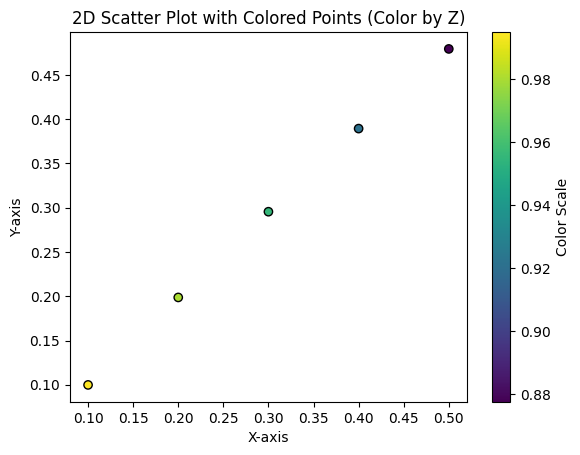

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Создаем данные для графика
x = [0.1, 0.2, 0.3, 0.4, 0.5]
y = np.sin(x)
z = np.cos(x)  # Добавим третью координату Z

# Создаем двумерный график с цветными точками
plt.scatter(x, y, c=z, cmap='viridis', marker='o', edgecolor='k')

# Добавляем цветовую шкалу
cbar = plt.colorbar()
cbar.set_label('Color Scale')

# Добавляем метки осей и заголовок
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('2D Scatter Plot with Colored Points (Color by Z)')

# Показываем график
plt.show()


Index(['length', 'clean_msg'], dtype='object')

In [33]:
import plotly.express as px
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2)
X_reduced = svd.fit_transform(X_train_dtm)

fig = px.scatter(
    X_reduced, x=0, y=1, color=y_train
)
fig.show()

X_reduced = svd.fit_transform(X_train_TFIDF)

fig = px.scatter(
    X_reduced, x=0, y=1, color=y_train
)
fig.show()

In [49]:
import numpy as np
lst = [[1,2,3], [2,1,3], [3,2,1]]
lst = np.array(lst)
lst[:,0]

array([1, 2, 3])

In [45]:
import gensim

word2vec_path = "~/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)